The purpose of this notebook is to check how many tokens we need for optimal language classification

In [2]:
import os
import logging
import pandas as pd
import numpy as np
import gc
logging.basicConfig(format='%(asctime)s - %(message)s', level=logging.INFO)


raw_dir = "/home/peterr/macocu/taskB/data/raw"
interim_dir = "/home/peterr/macocu/taskB/data/interim"
final_dir = "/home/peterr/macocu/taskB/data/final"

In [3]:
import parse
from typing import List


def get_N_tokens(N=5000, path="/home/peterr/macocu/taskB/task4/toy_tokens.csv") -> set:

    df = pd.read_csv("toy_tokens.csv", index_col=0)
    NUM_FEATS = N

    for column in df.columns:
        new_column_name = column + "_f"
        corpus_size = df[column].sum()
        df[new_column_name] = df[column] * 1e6 / corpus_size

    N = 1

    df["HR_SR"] = (df["hrwac_head_pp_f"] + N) / (df["srwac_head_pp_f"] + N)
    df["SR_HR"] = (df["srwac_head_pp_f"] + N) / (df["hrwac_head_pp_f"] + N)

    df["HR_CNR"] = (df["hrwac_head_pp_f"] + N) / (df["cnrwac_head_pp_f"] + N)
    df["CNR_HR"] = (df["cnrwac_head_pp_f"] + N) / (df["hrwac_head_pp_f"] + N)

    df["HR_BS"] = (df["hrwac_head_pp_f"] + N) / (df["bswac_head_pp_f"] + N)
    df["BS_HR"] = (df["bswac_head_pp_f"] + N) / (df["hrwac_head_pp_f"] + N)

    df["BS_SR"] = (df["bswac_head_pp_f"] + N) / (df["srwac_head_pp_f"] + N)
    df["SR_BS"] = (df["srwac_head_pp_f"] + N) / (df["bswac_head_pp_f"] + N)

    df["BS_CNR"] = (df["bswac_head_pp_f"] + N) / (df["cnrwac_head_pp_f"] + N)
    df["CNR_BS"] = (df["cnrwac_head_pp_f"] + N) / (df["bswac_head_pp_f"] + N)

    df["CNR_SR"] = (df["cnrwac_head_pp_f"] + N) / (df["srwac_head_pp_f"] + N)
    df["SR_CNR"] = (df["srwac_head_pp_f"] + N) / (df["cnrwac_head_pp_f"] + N)

    combos = ['HR_SR', 'SR_HR', 'HR_CNR', 'CNR_HR', 'HR_BS', 'BS_HR',
              'BS_SR', 'SR_BS', 'BS_CNR', 'CNR_BS', 'CNR_SR', 'SR_CNR']

    important_features = set()

    for lang_comb in combos:
        s = df[lang_comb].sort_values(ascending=False)
        current_features = s.index[:NUM_FEATS].values
        important_features = important_features.union(set(current_features))
    try:
        important_features.remove(np.nan)
    except KeyError:
        pass
    return important_features


def read_and_split_file(path: str) -> List[str]:
    texts = list()
    chunk = ""
    with open(path, "r") as f:
        content = f.readlines()
    for line in content:
        # Handle splits
        if line == "\n":
            texts.append(chunk)
            chunk = ""
        # Filter only lowercase alphabetical words:
        from utils import is_alpha
        line = line.replace("\n", " ")
        words = [w if is_alpha(w) else " " for w in line.split(" ")]
        chunk += " ".join(words)
    return texts


texts, labels = list(), list()

files = [
    "bswac_tail_pp",
    "cnrwac_tail_pp",
    "hrwac_tail_pp",
    "srwac_tail_pp"]

langs = ["bs", "me", "hr", "sr"]

for file, lang in zip(files, langs):
    full_path = os.path.join(interim_dir, file)
    current_texts = read_and_split_file(full_path)
    len_cur_texts = len(current_texts)
    texts.extend(current_texts)
    labels.extend([lang]*len_cur_texts)

train = pd.DataFrame(data={"text": texts, "labels": labels})

del texts, labels

SETimes = list()
for split in ["train", "test", "dev"]:
    with open(os.path.join(final_dir, f"{split}.fasttxt"), "r") as f:
        lines = f.readlines()
        SETimes.extend(lines)

p = parse.compile("__label__{lang} {text}")
langs = list()
texts = list()

for line in SETimes:
    results = p.parse(line)
    if not results:
        logging.error(f"Error parsing line {line}")
        continue
    langs.append(results["lang"])
    texts.append(results["text"])

eval_df = pd.DataFrame(data={"text": texts, "labels": langs})

del texts, langs, SETimes, line, lines, p


def get_stats(N: int):
    import gc
    import time
    from sklearn.naive_bayes import GaussianNB
    from sklearn.svm import LinearSVC
    from sklearn.feature_extraction.text import CountVectorizer
    gc.collect()
    start = time.time()
    vectorizer = CountVectorizer(
        vocabulary=get_N_tokens(N), lowercase=True, binary=True)

    train_vectors = vectorizer.fit_transform(train.text)
    train_labels = train.labels

    test_vectors = vectorizer.fit_transform(eval_df.text)
    y_true = eval_df.labels

    clf = LinearSVC(dual=False)
    train_start = time.time()
    clf.fit(train_vectors.toarray(), train_labels)
    predict_start = time.time()
    y_pred = clf.predict(test_vectors.toarray())
    predict_end = time.time()
    from sklearn.metrics import f1_score, ConfusionMatrixDisplay, confusion_matrix, accuracy_score
    import matplotlib.pyplot as plt
    LABELS = ["hr", "bs", "sr",  "me"]
    LABELS = ["hr", "bs", "sr",  "me"]

    macro = f1_score(y_true, y_pred, labels=LABELS, average="macro")
    micro = f1_score(y_true, y_pred, labels=LABELS,  average="micro")
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=LABELS)
    return {
        "N": N,
        "microF1": micro,
        "macroF1": macro,
        "accuracy": acc,
        "overall_time": time.time() - start,
        "cm": cm,
        "vectorizer_fitting": train_start - start,
        "training_time": predict_start - train_start,
        "predicting_time": predict_end - predict_start
    }


In [20]:

results = list()
Ns = np.logspace(1.1, 2.7, 40, dtype=np.int)
for N in Ns:
    try:
        gc.collect()
        logging.info(f"{N=}")
        cur_result = get_stats(N)
        logging.info(f"Done!")
        results.append(cur_result)
    except Exception as e:
        logging.error(f"For {N=} got Exception: {e}")

2022-01-04 16:33:46,799 - N=12
2022-01-04 16:35:47,073 - Done!
2022-01-04 16:35:47,186 - N=13
2022-01-04 16:37:30,935 - Done!
2022-01-04 16:37:31,036 - N=15
2022-01-04 16:39:26,124 - Done!
2022-01-04 16:39:26,179 - N=16
2022-01-04 16:41:28,615 - Done!
2022-01-04 16:41:28,669 - N=18
2022-01-04 16:43:26,954 - Done!
2022-01-04 16:43:27,007 - N=20
/home/peterr/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
2022-01-04 16:45:34,416 - Done!
2022-01-04 16:45:34,469 - N=22
/home/peterr/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
2022-01-04 16:47:46,143 - Done!
2022-01-04 16:47:46,195 - N=24
/home/peterr/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: Convergence

In [21]:
rezdf = pd.DataFrame(data=results)
rezdf.index = rezdf.N
rezdf = rezdf.drop(columns=["N"])
rezdf = rezdf.sort_index()
rezdf.tail(10)


,microF1,macroF1,accuracy,overall_time,cm,vectorizer_fitting,training_time,predicting_time
N,,,,,,,,
214,0.895765,0.742603,0.895765,240.427118,"[[83, 6, 0, 0], [3, 69, 2, 1], [2, 5, 387, 0],...",49.020720,191.375763,0.013726
235,0.900651,0.750301,0.900651,237.482042,"[[85, 4, 0, 0], [2, 70, 2, 1], [3, 4, 387, 0],...",49.200799,188.261897,0.011212
258,0.895765,0.749874,0.895765,236.746052,"[[85, 4, 0, 0], [2, 69, 2, 2], [5, 5, 384, 0],...",49.219367,187.508687,0.011308
284,0.895765,0.765321,0.895765,243.539081,"[[86, 3, 0, 0], [4, 66, 2, 3], [6, 6, 382, 0],...",49.431459,194.088903,0.006366
312,0.890879,0.749733,0.890879,247.967821,"[[85, 3, 0, 1], [4, 65, 3, 3], [6, 5, 383, 0],...",49.453431,198.492959,0.013988
343,0.892508,0.753096,0.892508,258.041600,"[[85, 4, 0, 0], [3, 67, 3, 2], [6, 6, 382, 0],...",49.558749,208.468579,0.007416
377,0.897394,0.757402,0.897394,290.179827,"[[84, 5, 0, 0], [2, 69, 2, 2], [3, 7, 384, 0],...",51.301631,238.864329,0.007175
414,0.890879,0.738984,0.890879,257.217375,"[[85, 4, 0, 0], [3, 66, 4, 2], [2, 8, 384, 0],...",49.369519,207.833632,0.007598
456,0.890879,0.740013,0.890879,253.660033,"[[84, 5, 0, 0], [3, 67, 3, 2], [3, 7, 384, 0],...",49.303586,204.341852,0.007894


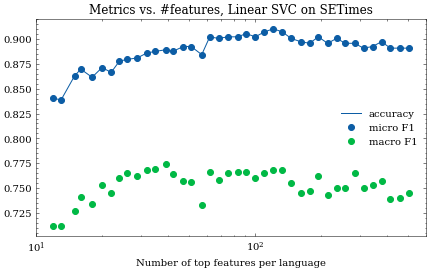

In [22]:
import matplotlib.pyplot as plt
plt.style.use(["science", "no-latex"])

plt.figure(figsize=(7, 4))
plt.scatter(rezdf.index, rezdf["microF1"],label="micro F1")

plt.scatter(rezdf.index, rezdf["macroF1"],label="macro F1")

plt.plot(rezdf.index, rezdf["accuracy"],label="accuracy")
plt.legend()
plt.title("Metrics vs. #features, Linear SVC on SETimes")
plt.xlabel("Number of top features per language")
plt.semilogx()
plt.savefig("images/16_metrics_LinearSVC_SETimes.png")
plt.show()

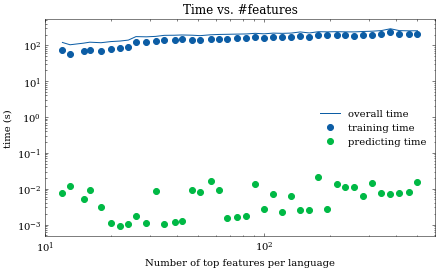

In [23]:
import matplotlib.pyplot as plt
plt.style.use(["science", "no-latex"])

plt.figure(figsize=(7, 4))
plt.scatter(rezdf.index, rezdf["training_time"],label="training time")

plt.scatter(rezdf.index, rezdf["predicting_time"],label="predicting time")

plt.plot(rezdf.index, rezdf["overall_time"],label="overall time")
plt.legend()
plt.title("Time vs. #features")
plt.xlabel("Number of top features per language")
plt.ylabel("time (s)")
plt.semilogx()
plt.semilogy()
plt.savefig("images/16_time_LinearSVC_SETimes.png")
plt.show()

In [24]:
rezdf.to_csv("16_results_SETimes.csv")

## Repeating the experiment with evaluation on Twitter data

Evaluation dataset will be overwritten with twitter dataset and the experiment will be rerun.

In [17]:
import pickle

with open("/home/peterr/macocu/taskB/data/final/twitter_full_ds.pickle", "rb") as f:
    twitter_ds = pickle.load(f)

users = twitter_ds.keys()
languages = [twitter_ds[user]["language"] for user in users]
tweets = [" ".join(twitter_ds[user]["tweets"]) for user in users]

eval_df = pd.DataFrame(data={"text": tweets, "labels": languages})

del users, languages, tweets, twitter_ds


results_tw = list()
Ns = np.logspace(1.2, 3, 15, dtype=np.int)
for N in Ns:
    try:
        gc.collect()
        logging.info(f"{N=}")
        cur_result = get_stats(N)
        logging.info(f"Done!")
        results_tw.append(cur_result)
    except Exception as e:
        logging.error(f"For {N=} got Exception: {e}")

2022-01-04 11:49:52,257 - N=15
2022-01-04 11:52:54,447 - Done!
2022-01-04 11:52:54,526 - N=21
/home/peterr/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
2022-01-04 11:56:21,838 - Done!
2022-01-04 11:56:21,958 - N=28
/home/peterr/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
2022-01-04 12:00:04,589 - Done!
2022-01-04 12:00:04,643 - N=38
/home/peterr/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
2022-01-04 12:04:05,465 - Done!
2022-01-04 12:04:05,524 - N=51
/home/peterr/anaconda3/lib/python3.8/site-packages/sklear

In [18]:
rezdf = pd.DataFrame(data=results_tw)
rezdf.index = rezdf.N
rezdf = rezdf.drop(columns=["N"])
rezdf = rezdf.sort_index()
rezdf.tail()

,microF1,macroF1,accuracy,overall_time,cm,vectorizer_fitting,training_time,predicting_time
N,,,,,,,,
305,0.894137,0.757940,0.894137,254.966307,"[[86, 2, 0, 1], [4, 65, 3, 3], [6, 5, 383, 0],...",50.164288,204.791012,0.004340
411,0.890879,0.738984,0.890879,276.288198,"[[85, 4, 0, 0], [3, 66, 4, 2], [2, 8, 384, 0],...",49.422446,226.852010,0.007054
553,0.900651,0.761909,0.900651,278.730448,"[[86, 3, 0, 0], [3, 68, 2, 2], [2, 7, 385, 0],...",49.502692,229.211998,0.009159
743,0.884365,0.742027,0.884365,295.550908,"[[80, 9, 0, 0], [3, 69, 2, 1], [2, 11, 380, 1]...",49.820486,245.705732,0.018052
1000,0.892508,0.756663,0.892508,285.860890,"[[81, 8, 0, 0], [2, 71, 1, 1], [4, 8, 381, 1],...",49.789260,236.042730,0.022295


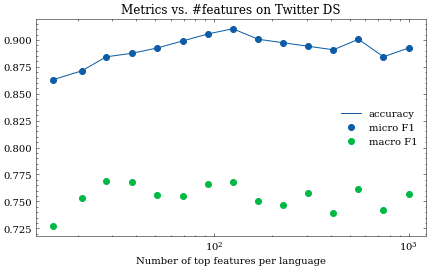

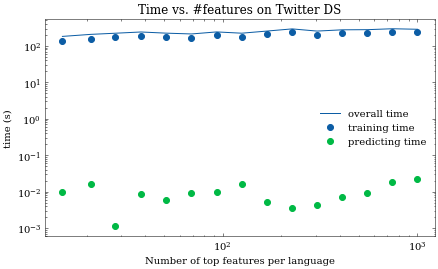

In [19]:
import matplotlib.pyplot as plt
plt.style.use(["science", "no-latex"])

plt.figure(figsize=(7, 4))
plt.scatter(rezdf.index, rezdf["microF1"],label="micro F1")

plt.scatter(rezdf.index, rezdf["macroF1"],label="macro F1")

plt.plot(rezdf.index, rezdf["accuracy"],label="accuracy")
plt.legend()
plt.title("Metrics vs. #features on Twitter DS")
plt.xlabel("Number of top features per language")
plt.semilogx()
plt.savefig("images/16_metrics_twitter.png")
plt.show()

plt.figure(figsize=(7, 4))
plt.scatter(rezdf.index, rezdf["training_time"],label="training time")

plt.scatter(rezdf.index, rezdf["predicting_time"],label="predicting time")

plt.plot(rezdf.index, rezdf["overall_time"],label="overall time")
plt.legend()
plt.title("Time vs. #features on Twitter DS")
plt.xlabel("Number of top features per language")
plt.ylabel("time (s)")
plt.semilogx()
plt.semilogy()
plt.savefig("images/16_time_twitter.png")
plt.show()

rezdf.to_csv("16_results_twitter.csv")

In [52]:
rezdf

,microF1,macroF1,accuracy,overall_time,cm,vectorizer_fitting,training_time,predicting_time
N,,,,,,,,
7,0.586844,0.430334,0.586844,50.188391,"[[2918, 186, 8, 84], [1868, 507, 292, 528], [5...",49.156408,0.933544,0.035966
11,0.650572,0.477448,0.650572,50.435889,"[[2838, 288, 5, 65], [1180, 753, 800, 462], [2...",49.222948,1.111228,0.041281
16,0.797472,0.606300,0.797472,51.649179,"[[2862, 271, 4, 59], [805, 1792, 319, 279], [5...",50.093741,1.438774,0.056639
24,0.797256,0.625015,0.797256,51.491914,"[[2762, 367, 2, 65], [421, 1831, 148, 795], [1...",49.480876,1.884453,0.066193
36,0.809462,0.639682,0.809462,52.517927,"[[2755, 389, 0, 52], [187, 1947, 137, 924], [5...",49.834522,2.528516,0.094284
52,0.825880,0.653083,0.825880,52.808194,"[[2817, 337, 2, 40], [165, 2035, 70, 925], [4,...",49.397205,3.225623,0.125307
76,0.837870,0.662655,0.837870,55.165068,"[[2865, 303, 0, 28], [122, 2085, 44, 944], [3,...",50.473727,4.426789,0.203544
100,0.855049,0.683520,0.855049,53.578132,"[[72, 16, 1, 0], [2, 64, 9, 0], [0, 11, 382, 1...",48.129265,5.431295,0.011853
112,0.850724,0.666355,0.850724,56.029038,"[[2854, 325, 0, 17], [113, 2336, 31, 715], [28...",49.813023,5.859840,0.296573
